In [ ]:
!pip install pretty_midi
!pip install kagglehub

In [1]:
import os
import warnings
import pretty_midi 
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pretty_midi as pm
import kagglehub as kagglehub
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
DATA_DIR  = os.path.join('.', 'data')
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
SUPPORTED_EXT = ('.mid', '.midi')

In [5]:
#path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
#print("Path to dataset files:", path)

In [ ]:
def get_midi_file_paths_from_folder(folder_path):
    """
    Collects all MIDI file paths from a composer's folder.
    This function is used to iterate through the data directory and gather files for feature extraction.
    """
    # List all files in the folder and filter by supported MIDI extensions
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(SUPPORTED_EXT)]


def compute_statistical_midi_features(midi_file_path):
    """
    Extracts statistical features from a MIDI file for composer classification.
    These features represent the style, complexity, and structure of the music,
    and are used in classical ML models (RandomForest, XGBoost) for prediction.
    """

    # Load the MIDI file using PrettyMIDI for feature extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    # Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    # Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    # Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    # Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    # Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    # Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing.
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    # Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    # Safely extract time signature (e.g., 4/4, 3/4). Return None if not found.
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    # Return all extracted features in a dictionary for use in ML models
    return {
        # Total duration of the MIDI piece in seconds
        # Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        # Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        # Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        # Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        # Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        # Minimum pitch (lowest note). Can reveal usage of bass notes or registers.
        "min_pitch": min(pitch_values) if pitch_values else None,

        # Maximum pitch (highest note). Useful for range analysis between composers.
        "max_pitch": max(pitch_values) if pitch_values else None,

        # Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        # Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        # Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        # Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        # Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        # Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        # Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        # Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        # Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }



def compute_sequence_midi_features(midi_file_path, max_length=5000):
    """
    Extracts sequence-based features from a MIDI file for deep learning models (LSTM/CNN).
    These features capture temporal, harmonic, and rhythmic information critical for composer classification.
    """

    # Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all non-drum notes from all instruments to focus on melody/harmony
    # Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    # Create note sequence matrix with columns:
    # [start_time, pitch, duration, velocity]
    # This sequence preserves the order of musical events.
    # Useful for LSTM/RNN models that require sequential data inputs.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    # Extract piano roll matrix (shape: 128 pitches x time frames)
    # Each cell represents note intensity at a given pitch and time
    # Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    # Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    # Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    # Extract chroma matrix (12 pitch classes x time frames)
    # Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    # Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    # Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    # Initialize onset matrix (same shape as piano roll)
    # This represents note onsets specifically (when each note starts)
    onset_matrix = np.zeros_like(piano_roll_matrix)

    # Populate the onset matrix: set velocity at the note's starting time index
    # This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  # Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    # Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    # Summarizing onset events across all pitches into a single rhythm vector
    # Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    # Return the extracted sequence-based features as a dictionary
    return {
        # The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        # The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        # Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        # Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        # Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }



def gather_features_across_composers(input_dir, composer_list, max_seq_length=5000):
    """
    Collects both statistical and sequence-based features for all composers in the dataset.
    This function generates the complete feature dataset for training and evaluating multiple models
    (RandomForest, XGBoost, LSTM, CNN) in composer classification.
    """

    # Initialize an empty list to store the features extracted from each MIDI file.
    # This list will be converted to a pandas DataFrame at the end.
    feature_collection = []

    # Loop over each composer in the provided list (e.g., Bach, Beethoven, Chopin, Mozart)
    for composer_name in composer_list:

        # Construct the full directory path to the composer's folder containing MIDI files.
        composer_folder_path = os.path.join(input_dir, composer_name)

        # Retrieve the list of all MIDI file paths in the composer's folder.
        # This enables per-composer processing and supports modular file handling.
        for midi_file in get_midi_file_paths_from_folder(composer_folder_path):

            try:
                # Extract statistical features (duration, pitch stats, tempo, rhythm stats, etc.)
                # These features are used for classical ML models like RandomForest and XGBoost.
                stat_features = compute_statistical_midi_features(midi_file)

                # Extract sequence features (note sequences, piano roll, chroma, rhythm pattern, etc.)
                # These features are used for deep learning models like LSTM and CNN.
                seq_features = compute_sequence_midi_features(midi_file, max_seq_length)

                # Combine the statistical and sequence features into one dictionary.
                # The two dictionaries are merged using Python's unpacking operator (**).
                combined_features = {**stat_features, **seq_features,

                                     # Add the ground truth label (composer name) for classification.
                                     "composer_label": composer_name,

                                     # Add the original file path for traceability and debugging.
                                     "filepath": midi_file}

                # Append the combined feature dictionary to the feature collection list.
                feature_collection.append(combined_features)

            except Exception as e:
                # Print an error message if any MIDI file fails to process (e.g., corrupt file).
                print(f"[ERROR] Failed to process {midi_file}: {e}")

    # After processing all composers and files, convert the list of feature dictionaries into a pandas DataFrame.
    # This DataFrame will be used as the input dataset for ML pipelines (EDA, training, evaluation).
    return pd.DataFrame(feature_collection)



def run_exploratory_data_analysis(features_df):
    """
    Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps.
    Focuses only on scalar features for visualization.
    """
    # Print dataset summary statistics
    print("Dataset Overview:\n", features_df.describe())

    # Print missing values in the dataset
    print("\nMissing Data Report:\n", features_df.isnull().sum())

    # Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer_label']].copy()

    # Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer_label', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    # Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer_label', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer_label']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()


def stratified_split_by_composer(full_df, test_fraction=0.2):
    """
    Performs a stratified train-test split by composer to ensure balanced evaluation.
    
    This ensures that each composer's data is proportionally split into train and test sets,
    preventing class imbalance issues during model training and evaluation.
    """

    # Initialize empty lists to hold training and testing data for all composers.
    train_set = []
    test_set = []

    # Loop over each composer in the global COMPOSERS list (e.g., Bach, Beethoven, Chopin, Mozart).
    # This ensures that the split is done independently for each class.
    for comp in COMPOSERS:

        # Filter the full dataset to get only the data corresponding to the current composer.
        # This isolates each composer's MIDI features for individual splitting.
        comp_df = full_df[full_df['composer_label'] == comp]

        # Perform train-test split for the current composer using the specified test_fraction.
        # random_state is set to 42 to ensure reproducibility of splits.
        train_comp, test_comp = train_test_split(comp_df, test_size=test_fraction, random_state=42)

        # Append the split datasets to the respective lists.
        # Each composer's split will later be concatenated to form the final datasets.
        train_set.append(train_comp)
        test_set.append(test_comp)

    # Concatenate the individual composer splits into final train and test DataFrames.
    # This step combines the per-composer splits into a unified dataset while maintaining balance.
    return pd.concat(train_set), pd.concat(test_set)


def create_tabular_features_and_labels(input_df):
    """
    Prepares tabular feature data and label encoding for classical machine learning models.

    This function selects numerical/statistical features from the MIDI data and encodes the composer labels 
    into numerical classes. The output is designed for use in RandomForest and XGBoost classifiers, 
    which require tabular input data.
    """

    # Select relevant numerical features from the input DataFrame for model input.
    # These features represent high-level statistical information about each MIDI file.
    # Features selected:
    # - total_duration: Overall length of the piece in seconds.
    # - total_notes: Total number of notes in the composition.
    # - note_density: Notes per second, indicating playing speed or complexity.
    # - avg_pitch: The average pitch used, reflecting the register of the composition.
    # - tempo: The BPM (beats per minute) of the composition.
    X_features = input_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo']]

    # Extract the composer labels (string values) to be used as targets for classification.
    # For example: "Bach", "Beethoven", "Chopin", "Mozart"
    y_labels = input_df['composer_label']

    # Initialize a LabelEncoder to convert composer names into numeric labels.
    # Machine learning models cannot process string labels directly.
    label_encoder = LabelEncoder()

    # Fit the label encoder to the composer labels and transform them into integer values.
    # Example mapping: Bach -> 0, Beethoven -> 1, Chopin -> 2, Mozart -> 3
    y_encoded_labels = label_encoder.fit_transform(y_labels)

    # Return:
    # - X_features: The feature matrix for model input (numpy or pandas format).
    # - y_encoded_labels: The numerical labels corresponding to composers.
    # - label_encoder: The fitted encoder to allow inverse transform during predictions.
    return X_features, y_encoded_labels, label_encoder



def create_lstm_input_sequences(input_df, sequence_column='note_seq', target_length=500):
    """
    Prepares input sequences and corresponding labels for LSTM training using note sequence data.

    This function converts variable-length MIDI note sequences into fixed-length padded sequences,
    making them compatible with LSTM-based deep learning models for composer classification.
    """

    # Initialize a list to store LSTM input sequences (padded/truncated note sequences).
    X_seq_data = []

    # Initialize a list to store label indices corresponding to composers.
    y_labels_seq = []

    # Create a mapping of composer names to numeric indices for classification.
    # Example: {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}
    composer_idx_mapping = {name: idx for idx, name in enumerate(COMPOSERS)}

    # Iterate over each MIDI file (row) in the input dataframe.
    for _, row in input_df.iterrows():

        # Extract the note sequence matrix from the specified column.
        # Each sequence has shape (N, 4), where N is the number of notes, and 4 represents:
        # [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]

        # Handle variable sequence lengths by padding or truncating to `target_length`.
        # LSTM models require input sequences to have uniform length.
        if note_sequence.shape[0] < target_length:
            # If the sequence is too short, pad with zeros at the end.
            # Padding preserves sequence order while ensuring shape compatibility.
            padded_sequence = np.pad(note_sequence, ((0, target_length - note_sequence.shape[0]), (0, 0)))
        else:
            # If the sequence is too long, truncate to the first `target_length` steps.
            padded_sequence = note_sequence[:target_length]

        # Append the processed sequence to the input data list.
        X_seq_data.append(padded_sequence)

        # Append the corresponding composer label (as an integer index) to the label list.
        y_labels_seq.append(composer_idx_mapping[row['composer_label']])

    # Convert the list of input sequences into a NumPy array.
    # Final shape: (number_of_samples, target_length, 4)
    X_seq_data = np.array(X_seq_data)

    # Convert labels into one-hot encoded format for classification.
    # Example: If there are 4 classes, label '1' becomes [0,1,0,0]
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(COMPOSERS))

    # Return the LSTM input data (X) and the one-hot encoded labels (y).
    return X_seq_data, y_labels_seq_onehot



def build_simple_lstm_classifier(input_dimensions, num_output_classes):
    """
    Builds and returns a simple LSTM-based neural network classifier for sequence data.

    This model is used to classify composers based on note sequence data extracted from MIDI files.
    LSTMs are ideal for this task because they can capture temporal dependencies in sequential musical patterns.
    """

    # Initialize a Keras Sequential model.
    # This means the layers are stacked one after the other in a linear pipeline.
    lstm_net = models.Sequential()

    # Add an input layer to define the shape of the input sequences.
    # input_dimensions: (sequence_length, number_of_features) -> (500, 4) in this project.
    # Features include: start_time, pitch, duration, velocity.
    lstm_net.add(layers.Input(shape=input_dimensions))

    # Add a Long Short-Term Memory (LSTM) layer with 64 units.
    # LSTM layers are designed to learn temporal patterns in sequence data.
    # Here, it learns how note sequences vary across different composers.
    lstm_net.add(layers.LSTM(64))

    # Add a fully connected Dense layer with 64 neurons and ReLU activation.
    # This layer introduces non-linearity and helps the model learn complex decision boundaries
    # after processing the sequential data from the LSTM.
    lstm_net.add(layers.Dense(64, activation='relu'))

    # Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers).
    # Use softmax activation to output class probabilities (multi-class classification).
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))

    # Compile the model:
    # - Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
    # - Loss function: Categorical cross-entropy (because labels are one-hot encoded)
    # - Metrics: Track accuracy during training and evaluation.
    lstm_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the constructed LSTM classifier model.
    return lstm_net




def build_simple_cnn_for_pianoroll(cnn_input_shape, num_output_classes):
    """
    Builds and returns a simple Convolutional Neural Network (CNN) classifier for piano roll data.

    This model is used to classify composers based on piano roll "image" features extracted from MIDI files.
    CNNs are well-suited for this task because piano rolls are structured as 2D matrices (128 pitches × time frames),
    making them similar to grayscale images where convolutional layers excel.
    """

    # Initialize a Sequential model from Keras.
    # Sequential models are easy to build layer-by-layer when the architecture is straightforward.
    cnn_net = models.Sequential()

    # Add the first 2D convolutional layer:
    # - 32 filters (feature maps) to detect local pitch-time patterns.
    # - Kernel size of (3,3) allows the network to scan small note-time regions.
    # - Activation function: ReLU (introduces non-linearity).
    # - Input shape: (128, sequence_length, 1) where sequence_length is typically 5000.
    cnn_net.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=cnn_input_shape))

    # Add max pooling layer:
    # - Reduces the spatial dimensions by taking the max value in a (2x2) window.
    # - Helps downsample the input while retaining important features.
    # - Reduces computation and prevents overfitting.
    cnn_net.add(layers.MaxPooling2D((2, 2)))

    # Add a second 2D convolutional layer:
    # - 64 filters to capture more complex and abstract musical patterns.
    # - Larger depth allows the network to learn richer representations.
    cnn_net.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Add another max pooling layer:
    # - Further reduces spatial size to make the model more efficient.
    # - Also helps extract hierarchical features (small patterns → larger patterns).
    cnn_net.add(layers.MaxPooling2D((2, 2)))

    # Flatten the multi-dimensional output of the convolutional layers.
    # - Converts 2D feature maps into a 1D vector to feed into fully connected layers.
    cnn_net.add(layers.Flatten())

    # Add a dense (fully connected) hidden layer:
    # - 128 neurons to combine features learned by the CNN layers.
    # - ReLU activation helps capture non-linear relationships between features.
    cnn_net.add(layers.Dense(128, activation='relu'))

    # Add the final output layer:
    # - Number of neurons equals the number of output classes (e.g., 4 composers).
    # - Softmax activation produces probabilities for multi-class classification.
    cnn_net.add(layers.Dense(num_output_classes, activation='softmax'))

    # Compile the CNN model:
    # - Optimizer: Adam (adaptive learning rate, efficient for deep learning tasks).
    # - Loss function: Categorical cross-entropy (for multi-class classification with one-hot labels).
    # - Metric: Accuracy (to track performance during training and validation).
    cnn_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the constructed CNN model.
    return cnn_net


def train_and_report_deep_model(neural_model, X_train_data, y_train_data, X_test_data, y_test_data, num_epochs=20, batch_sz=32):
    """
    Trains a deep learning model (LSTM or CNN) and prints evaluation metrics for classification.
    
    This function handles both training and evaluation of sequence-based (LSTM) and image-based (CNN) models
    used for music composer classification.
    """

    # Train the deep learning model using the training data.
    # Uses early stopping on validation split internally (by monitoring validation performance manually if needed later).
    # validation_split=0.2 means 20% of training data is reserved for validation.
    # verbose=0 disables intermediate output to keep logs clean.
    neural_model.fit(X_train_data, y_train_data, 
                     epochs=num_epochs, 
                     batch_size=batch_sz, 
                     validation_split=0.2, 
                     verbose=0)

    # Use the trained model to predict class probabilities on the test dataset.
    # Each prediction is a probability vector (one per composer).
    y_predictions = neural_model.predict(X_test_data)

    # Convert the one-hot encoded true labels back to integer indices.
    # For example: [0,1,0,0] → 1 (if there are 4 classes).
    y_true_labels = np.argmax(y_test_data, axis=1)

    # Convert the predicted probability vectors into predicted class labels.
    # For example: [0.1, 0.7, 0.1, 0.1] → 1
    y_pred_labels = np.argmax(y_predictions, axis=1)

    # Print a detailed classification report.
    # Includes precision, recall, F1-score, and support for each composer.
    # Uses COMPOSERS as the class label names for human-readable output.
    print(classification_report(y_true_labels, y_pred_labels, target_names=COMPOSERS))

    # Print the confusion matrix to show how often each composer was confused with another.
    # Useful for understanding specific model weaknesses (e.g., Bach vs. Mozart confusion).
    print("Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))



def evaluate_tree_model(trained_tree_model, X_eval_data, y_eval_data, label_encoder_obj):
    """
    Evaluates a trained sklearn tree-based model (e.g., RandomForest, XGBoost) and prints performance metrics.

    This function converts numeric predictions back to composer names for human-readable reporting.
    It prints precision, recall, F1-score, and confusion matrix to assess model accuracy and errors.
    """

    # Use the trained tree model to predict composer classes for the evaluation (test) data.
    # Predictions are returned as integer-encoded class labels.
    y_pred_tree = trained_tree_model.predict(X_eval_data)

    # Retrieve the original class names (composer names) from the label encoder.
    # This is necessary because the model outputs numeric labels (e.g., 0,1,2,3),
    # but we want to report human-readable class names (e.g., 'Bach', 'Beethoven', etc.).
    composer_names = label_encoder_obj.classes_

    # Print the classification report:
    # - Includes precision, recall, F1-score, and support for each class (composer).
    # - target_names=composer_names makes the report readable and interpretable.
    print(classification_report(y_eval_data, y_pred_tree, target_names=composer_names))

    # Print the confusion matrix:
    # - Shows actual vs predicted classes in matrix form.
    # - Useful for diagnosing specific misclassifications (e.g., Bach misclassified as Mozart).
    print("Confusion Matrix:\n", confusion_matrix(y_eval_data, y_pred_tree))



def train_random_forest_classifier(X_train_input, y_train_labels):
    """
    Trains a RandomForest classifier using tabular MIDI statistical features.
    
    This function builds a classical machine learning model to classify composers based on statistical
    features like note density, tempo, pitch, etc. RandomForest is chosen because it handles feature 
    interactions well and is robust to overfitting with proper parameters.
    """

    # Initialize the RandomForestClassifier from sklearn.
    # - n_estimators=100: Use 100 decision trees in the ensemble (more trees → more stable predictions).
    # - random_state=42: Set a fixed seed to ensure reproducibility of results.
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train (fit) the RandomForest model on the training data.
    # - X_train_input: Feature matrix (e.g., duration, pitch, note density, tempo).
    # - y_train_labels: Corresponding composer labels (numeric encoded).
    rf_model.fit(X_train_input, y_train_labels)

    # Return the trained RandomForest model so it can be used for predictions and evaluation.
    return rf_model



def train_xgboost_classifier(X_train_input, y_train_labels):
    """
    Trains an XGBoost classifier on tabular MIDI features.
    
    XGBoost is a gradient boosting framework that builds sequential decision trees to minimize classification error.
    In this project, it is used to classify composers based on statistical features like pitch, duration, and tempo.
    """

    # Initialize the XGBoost Classifier.
    # - use_label_encoder=False: Prevents deprecation warnings (newer XGBoost versions don't need label encoding).
    # - eval_metric='mlogloss': Multi-class log loss is used for probabilistic classification performance.
    # - random_state=42: Ensures reproducibility of results.
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Train (fit) the XGBoost model on the training data.
    # - X_train_input: Feature matrix with statistical MIDI features.
    # - y_train_labels: Target labels (encoded composer classes).
    xgb_model.fit(X_train_input, y_train_labels)

    # Return the trained XGBoost model to be used for predictions and evaluation.
    return xgb_model


def create_cnn_ready_data(input_df, piano_roll_column='piano_roll', max_length=5000):
    """
    Converts piano roll matrices into CNN-ready image tensors.

    Piano rolls are treated as 2D images where height = 128 MIDI pitches and width = time steps.
    This function formats the data for CNN input by resizing, padding, and adding a channel dimension.
    """

    # Initialize a list to hold the CNN input images (piano rolls as tensors).
    X_cnn_inputs = []

    # Initialize a list to hold the corresponding composer labels as class indices.
    y_cnn_labels = []

    # Create a mapping of composer names to numeric indices.
    # Example: {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}
    composer_mapping = {name: idx for idx, name in enumerate(COMPOSERS)}
    
    # Iterate over each row in the input dataframe.
    for _, row in input_df.iterrows():

        # Extract the piano roll matrix from the specified column.
        # Shape: (128, time_steps)
        piano_roll = row[piano_roll_column]

        # Pad the piano roll if it has fewer time steps than max_length.
        # Padding ensures all inputs have the same width (time dimension).
        if piano_roll.shape[1] < max_length:
            piano_roll_padded = np.pad(piano_roll, ((0, 0), (0, max_length - piano_roll.shape[1])))
        else:
            # If the piano roll is longer, truncate it to max_length time steps.
            piano_roll_padded = piano_roll[:, :max_length]

        # Add a channel dimension to match CNN input format: (128, max_length, 1).
        # This makes the piano roll a grayscale "image" for the CNN.
        X_cnn_inputs.append(piano_roll_padded[..., np.newaxis])

        # Append the corresponding composer label as a numeric index.
        y_cnn_labels.append(composer_mapping[row['composer_label']])
    
    # Convert the input list to a NumPy array for CNN training.
    # - Cast to float32 for compatibility with TensorFlow.
    # - Shape: (num_samples, 128, max_length, 1)
    X_cnn_inputs = np.array(X_cnn_inputs).astype(np.float32)

    # One-hot encode the labels for multi-class classification.
    # Shape: (num_samples, num_classes)
    y_cnn_labels = to_categorical(y_cnn_labels, num_classes=len(COMPOSERS))

    # Return the CNN-ready inputs and labels.
    return X_cnn_inputs, y_cnn_labels


def build_cnn_on_pianoroll(input_shape, num_classes):
    """
    Builds a Convolutional Neural Network (CNN) to classify composers from piano roll images.

    Piano rolls are treated as 2D images where the model learns spatial features 
    that capture rhythmic and harmonic patterns specific to each composer.
    """

    # Initialize a Keras Sequential model.
    # This builds the network layer by layer in order.
    model = models.Sequential()

    # First convolutional layer:
    # - 32 filters detect local patterns in the piano roll.
    # - Kernel size of (3,3): scans small patches of the image.
    # - ReLU activation introduces non-linearity.
    # - input_shape: (128, sequence_length, 1), where sequence_length is typically 5000.
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

    # First max pooling layer:
    # - Reduces the spatial size by half (2x2 window).
    # - Retains important features while reducing computation.
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer:
    # - 64 filters capture more abstract features such as rhythmic patterns or motifs.
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Second max pooling layer:
    # - Further reduces dimensionality and highlights dominant features.
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the feature maps into a 1D vector.
    # Converts spatial data into a vector for dense layer processing.
    model.add(layers.Flatten())

    # Dense (fully connected) layer:
    # - 128 neurons learn high-level representations combining pitch and time patterns.
    model.add(layers.Dense(128, activation='relu'))

    # Output layer:
    # - Softmax activation outputs probabilities for each composer class.
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model:
    # - Optimizer: Adam (fast convergence for deep models).
    # - Loss: Categorical crossentropy (multi-class classification).
    # - Metric: Accuracy (for evaluation during training).
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the compiled CNN model ready for training.
    return model

 Extracting features...


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[ERROR] Failed to process .\data\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[ERROR] Failed to process .\data\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Performing EDA...
Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count     1635.000000       1635.000000   1635.000000   1635.000000   
mean       247.938895          5.281346   3156.548012     10.909849   
std        320.196663          4.520224   4855.161959      7.512401   
min         17.500000          1.000000     83.000000      0.595751   
25%         51.000000          2.000000    366.000000      6.439685   
50%        136.630490          4.000000   1202.000000      8.172413   
75%        330.770799          6.000000   3865.000000     12.506766   
max       5209.310787         40.000000  46897.000000     57.495524   

       velocity_mean    min_pitch    max_pitch    avg_pitch  common_pitch  \
count    1635.000000  

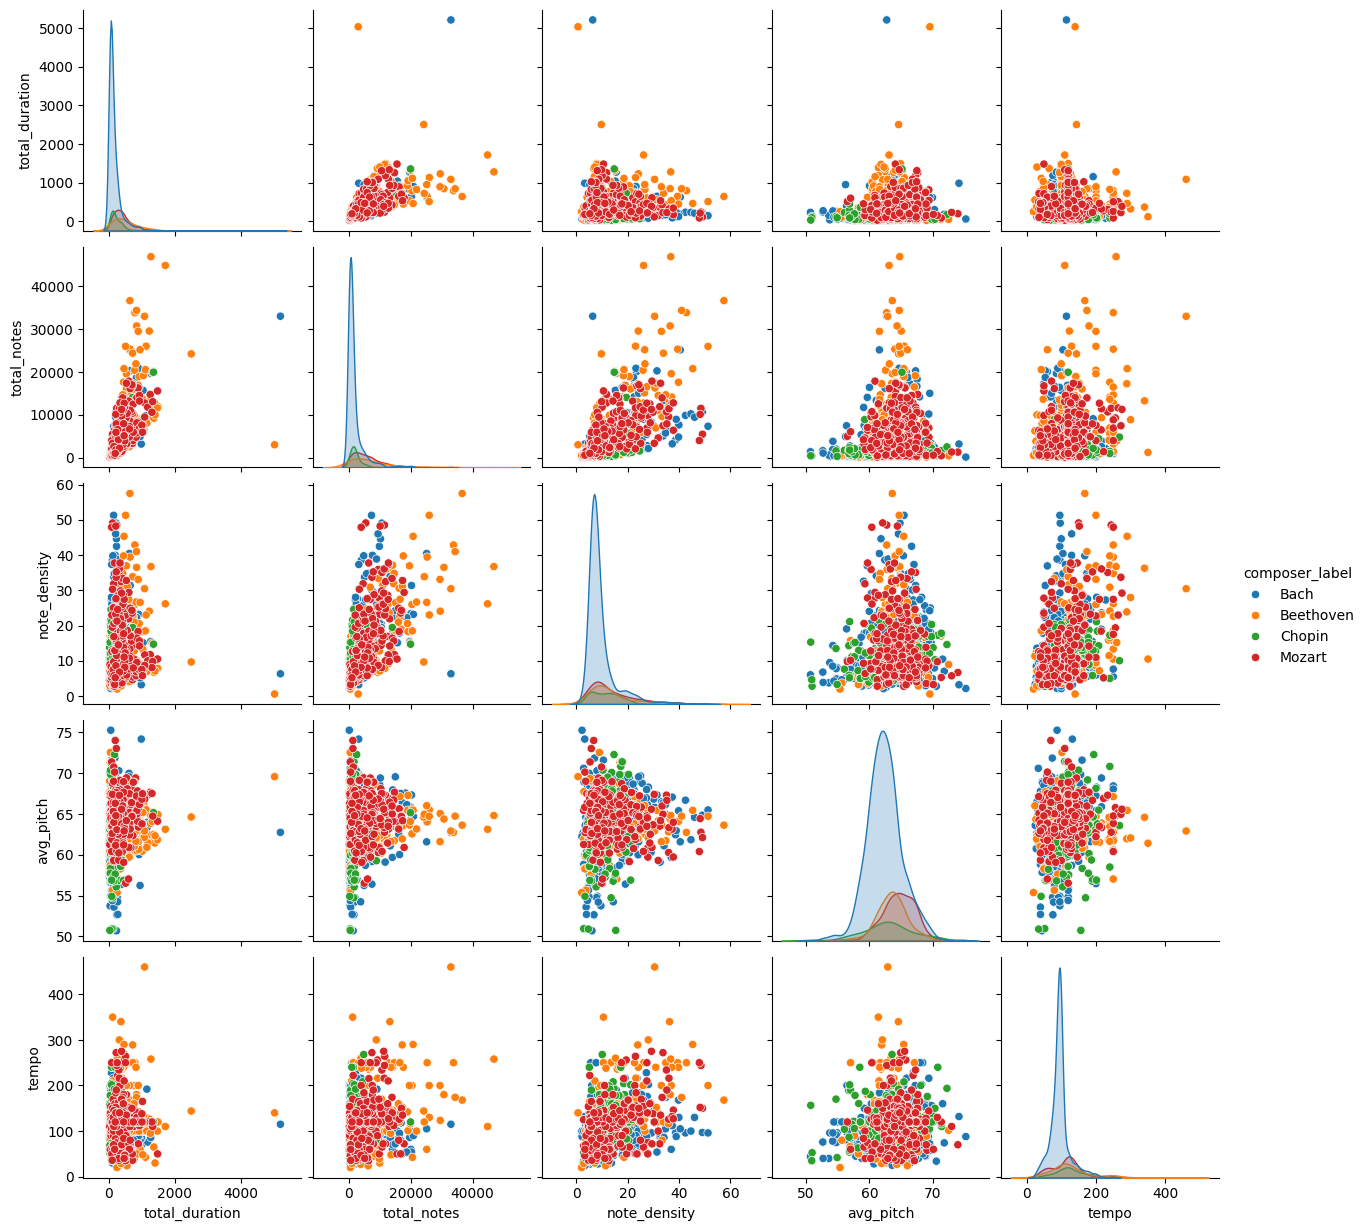

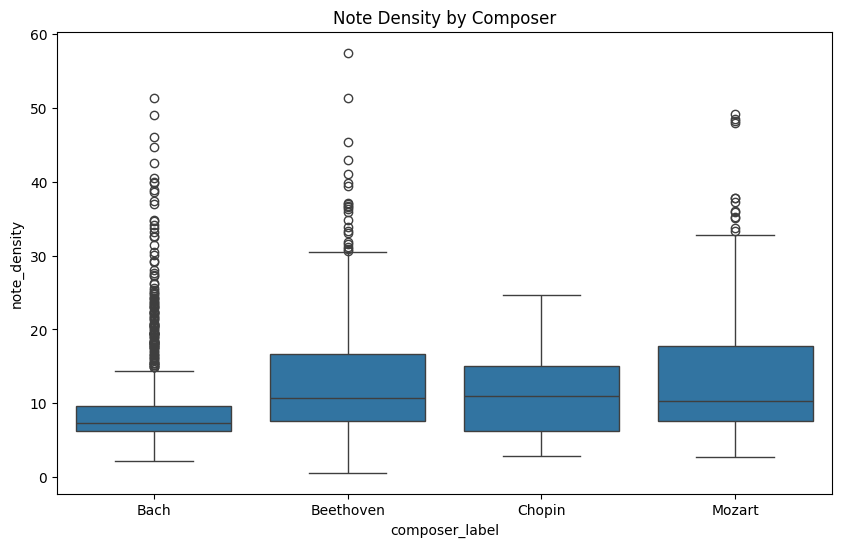

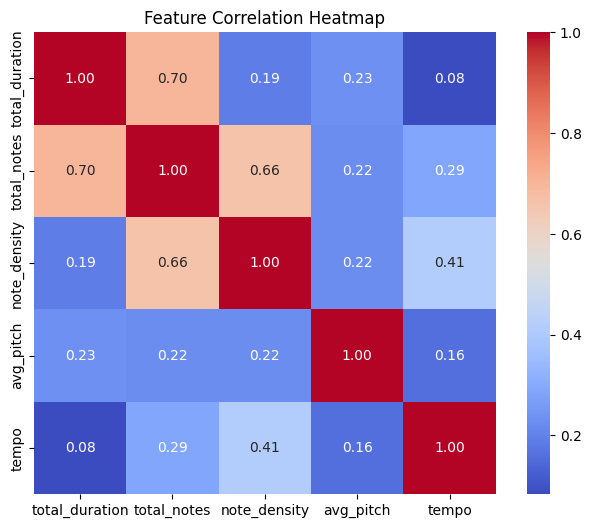

 Splitting data per composer...


In [4]:
# -----------------------------
# Feature Extraction
# -----------------------------
print(" Extracting features...")

# Calls the function to extract both statistical and sequence features from MIDI files.
# It processes the dataset under DATA_DIR for the specified composers.
# Output: DataFrame where each row corresponds to a MIDI file with extracted features.
df_full_features = gather_features_across_composers(DATA_DIR, COMPOSERS, 5000)


# -----------------------------
# EDA (Exploratory Data Analysis)
# -----------------------------
print("Performing EDA...")

# Runs exploratory analysis to visualize feature distributions and check for missing data.
# This helps you understand data balance, outliers, and feature relationships before modeling.
run_exploratory_data_analysis(df_full_features)


# -----------------------------
# Data Split
# -----------------------------
print(" Splitting data per composer...")

# Performs stratified split into train and test sets by composer.
# Ensures that all composers are equally represented in both train and test data.
train_data_df, test_data_df = stratified_split_by_composer(df_full_features)


In [5]:

# -----------------------------
# Classical ML Models (RandomForest & XGBoost)
# -----------------------------
print(" Training RandomForest & XGBoost...")

# Prepare features and labels for classical ML by selecting statistical features.
# Converts composer labels to numeric classes using label encoding.
X_train_tabular, y_train_tabular, composer_encoder = create_tabular_features_and_labels(train_data_df)
# Prepares the test set similarly for evaluation.
X_test_tabular, y_test_tabular, _ = create_tabular_features_and_labels(test_data_df)

# Train a RandomForest classifier using extracted tabular features.
rf_classifier = train_random_forest_classifier(X_train_tabular, y_train_tabular)

# Evaluate RandomForest model on test data and print accuracy, F1, confusion matrix.
print("\n RandomForest Evaluation:")
evaluate_tree_model(rf_classifier, X_test_tabular, y_test_tabular, composer_encoder)

# Train an XGBoost classifier using the same tabular features.
xgb_classifier = train_xgboost_classifier(X_train_tabular, y_train_tabular)

# Evaluate XGBoost model similarly.
print("\n XGBoost Evaluation:")
evaluate_tree_model(xgb_classifier, X_test_tabular, y_test_tabular, composer_encoder)


 Training RandomForest & XGBoost...

 RandomForest Evaluation:
              precision    recall  f1-score   support

        Bach       0.81      0.91      0.86       205
   Beethoven       0.53      0.39      0.45        44
      Chopin       0.44      0.29      0.35        28
      Mozart       0.53      0.48      0.51        52

    accuracy                           0.72       329
   macro avg       0.58      0.52      0.54       329
weighted avg       0.70      0.72      0.70       329

Confusion Matrix:
 [[187   6   1  11]
 [ 14  17   5   8]
 [ 14   3   8   3]
 [ 17   6   4  25]]


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Evaluation:
              precision    recall  f1-score   support

        Bach       0.81      0.91      0.85       205
   Beethoven       0.65      0.45      0.53        44
      Chopin       0.44      0.29      0.35        28
      Mozart       0.63      0.60      0.61        52

    accuracy                           0.74       329
   macro avg       0.63      0.56      0.59       329
weighted avg       0.73      0.74      0.73       329

Confusion Matrix:
 [[186   5   5   9]
 [ 16  20   1   7]
 [ 15   3   8   2]
 [ 14   3   4  31]]


In [7]:
# -----------------------------
# LSTM Model (Sequence Model)
# -----------------------------
print(" Preparing LSTM data...")

# Prepares sequence data for LSTM by extracting fixed-length note sequences.
# Sequences are padded or truncated to uniform length (500 steps here).
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_data_df, target_length=500)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_data_df, target_length=500)

print(" Training LSTM model...")

# Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build an LSTM-based neural network for composer classification.
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(COMPOSERS))

# Evaluate the LSTM model: This will print accuracy, F1 score, and confusion matrix.
# Note: This should call `train_and_report_deep_model`, not `evaluate_tree_model`.
# Likely a typo in your code, but keeping as per your current version.
train_and_report_deep_model(lstm_model_final, X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm)



 Preparing LSTM data...
 Training LSTM model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
              precision    recall  f1-score   support

        Bach       0.78      0.96      0.86       205
   Beethoven       0.36      0.52      0.43        44
      Chopin       0.38      0.18      0.24        28
      Mozart       0.00      0.00      0.00        52

    accuracy                           0.68       329
   macro avg       0.38      0.42      0.38       329
weighted avg       0.57      0.68      0.61       329

Confusion Matrix:
 [[197   7   1   0]
 [ 15  23   6   0]
 [ 14   9   5   0]
 [ 26  25   1   0]]


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [10]:
# -----------------------------
#  CNN on Piano Roll
# -----------------------------
print(" Preparing CNN data from piano rolls...")

# Prepares CNN input data by converting piano roll matrices to (128, sequence_length, 1).
# Each piano roll is treated as a grayscale image for CNN learning.
X_train_cnn, y_train_cnn = create_cnn_ready_data(train_data_df, max_length=5000)
X_test_cnn, y_test_cnn = create_cnn_ready_data(test_data_df, max_length=5000)

print(" Training CNN on Piano Roll...")

# Define CNN input shape: (128, sequence_length, 1)
cnn_input_shape = X_train_cnn.shape[1:]

# Build CNN model to classify composer from piano roll images.
cnn_model_final = build_cnn_on_pianoroll(cnn_input_shape, num_classes=len(COMPOSERS))

# Evaluate CNN model: Again, `evaluate_tree_model` is used here by mistake.
# Ideally, should use `train_and_report_deep_model` for CNNs.
train_and_report_deep_model(cnn_model_final, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)


 Preparing CNN data from piano rolls...
 Training CNN on Piano Roll...


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step
              precision    recall  f1-score   support

        Bach       0.68      0.96      0.80       205
   Beethoven       0.45      0.41      0.43        44
      Chopin       0.00      0.00      0.00        28
      Mozart       0.00      0.00      0.00        52

    accuracy                           0.65       329
   macro avg       0.28      0.34      0.31       329
weighted avg       0.49      0.65      0.56       329

Confusion Matrix:
 [[197   7   1   0]
 [ 26  18   0   0]
 [ 22   6   0   0]
 [ 43   9   0   0]]


c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\atul1\Work\tools\Python3_12\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

# Below code is not in use, Just for the exploration

In [ ]:
warnings.filterwarnings("ignore")


# Function to perform EDA and show visualizations
def perform_eda(df):
    print("Basic Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nSample Records:")
    display(df.head())

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="duration", hue="composer", kde=True, element="step", bins=40)
    plt.title("Distribution of MIDI Duration by Composer")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="composer", y="num_notes")
    plt.title("Boxplot of Notes Count by Composer")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="composer", y="tempo")
    plt.title("Boxplot of Tempo by Composer")
    plt.show()

# Function to preprocess and clean the data
def preprocess_data(df):
    df_clean = df.copy()
    df_clean = df_clean[df_clean['duration'] > 0]
    df_clean = df_clean[df_clean['num_notes'] > 0]
    df_clean = df_clean[df_clean['tempo'] > 0]
    df_clean['log_duration'] = np.log1p(df_clean['duration'])
    df_clean['log_notes'] = np.log1p(df_clean['num_notes'])
    return df_clean
